# Tutorial 11 - Tonsil (10x Visium Spatial Gene and Protein)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Tonsil_10x'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path, 'female/adata_female_rna.h5ad'))
adata1_adt = sc.read_h5ad(os.path.join(file_path, 'female/adata_female_adt.h5ad'))
adata2_rna = sc.read_h5ad(os.path.join(file_path, 'male/adata_male_rna.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path, 'male/adata_male_adt.h5ad'))

adata1_rna, adata1_adt, adata2_rna, adata2_adt

(AnnData object with n_obs × n_vars = 474517 × 3000
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 474517 × 35
     obsm: 'UNI_feature', 'spatial',
 AnnData object with n_obs × n_vars = 514434 × 3000
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 514434 × 39
     obsm: 'UNI_feature', 'spatial')

In [5]:
adata1_rna.var_names_make_unique()
adata2_adt.var_names_make_unique()

In [6]:
adata1_he = sc.AnnData(X=adata1_adt.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_adt.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata1_adt.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_adt.obsm['spatial'].copy()
adata1_he, adata2_he

(AnnData object with n_obs × n_vars = 474517 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 514434 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data

In [7]:
data_dict = {
        'HE': [adata1_he, adata2_he],
        'RNA': [adata1_rna, None],
        'Protein': [None, adata2_adt],
    }

In [8]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-06-10 19:50:54,601 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-10 19:51:16,417 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-10 19:51:18,549 - harmonypy - INFO - Iteration 1 of 10
2025-06-10 19:53:27,877 - harmonypy - INFO - Iteration 2 of 10
2025-06-10 19:55:34,867 - harmonypy - INFO - Converged after 2 iterations


-------- Processing unique modality RNA for section 1 --------
-------- Processing unique modality Protein for section 2 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the linkage indicator

In [11]:
Linkage_indicator = {
        ('s1', 's2'): [ ('RNA', 'Protein')]
    }


## Define COSIE model and perform integration

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=1, n_y=2)

-------- Running Sub-graph training mode, n_x is 1, n_y is 2 --------
Splitting section [s1] into 1 x 2 subgraphs
Splitting HE in section s1...
Splitting RNA in section s1...
Splitting section [s2] into 1 x 2 subgraphs
Splitting HE in section s2...
Splitting Protein in section s2...
Computing linkage between [RNA] (s1-0) and [Protein] (s2-0)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-0) and [Protein] (s2-1)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein] (s2-0)
Number of overlapping features: 18
Computing linkage between [RNA] (s1-1) and [Protein] (s2-1)
Number of overlapping features: 18
Model moved to cuda:0!
---------------- Constructing Full Graph ----------------
-------- Constructing full spatial graph for s1 --------
 Constructing full feature graph for [s1 - HE]...
 Constructing full feature graph for [s1 - RNA]...
-------- Constructing full spatial graph for s2 --------
 Constructing full feature graph for [s2

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [09:41<00:00,  1.03it/s]


 Running Evaluation...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s1 using modality [HE]
Missing modality [RNA] in Section [s2]
Using predictor [HE → RNA] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [HE]
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Tonsil_10x


## Perform clustering and visualization

Perform joint clustering...


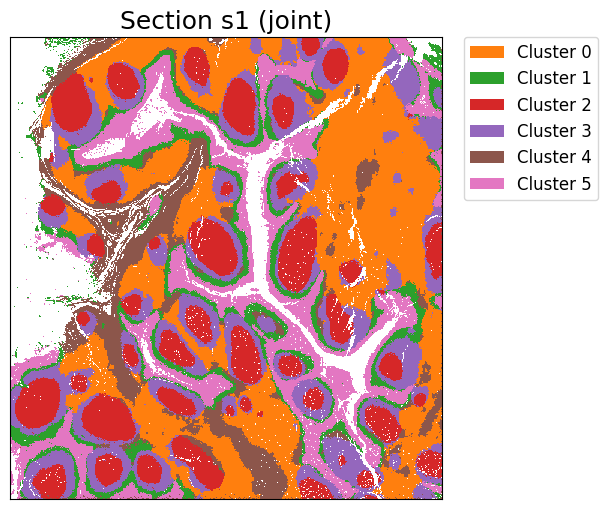

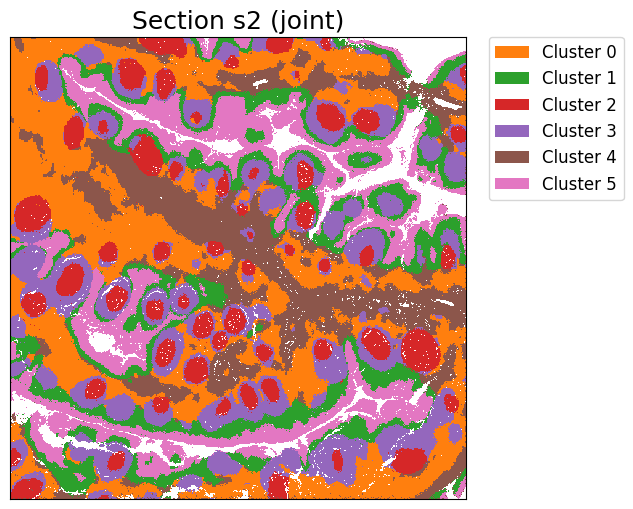

In [20]:
cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=6,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 figscale = 120)

## Perform prediction

##### Protein prediction for Section 1 

In [21]:
adata1_protein_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
[Protein] exists in ['s2'], which will be used as source data section


In [22]:
adata1_protein_predicted

AnnData object with n_obs × n_vars = 474517 × 39
    obsm: 'spatial'

In [23]:
adata1_protein_predicted_norm = create_normalized_adata(adata1_protein_predicted)
adata1_adt_norm = create_normalized_adata(adata1_adt)

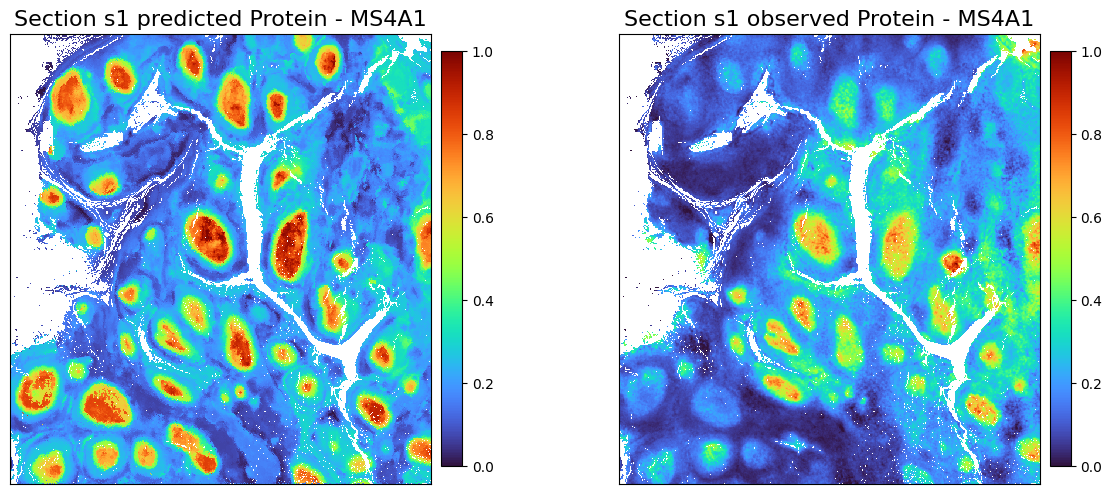

In [24]:
chosed_protein = 'MS4A1'
plot_marker_comparison_superpixel(chosed_protein, 
                                  adata1_protein_predicted_norm, 
                                  adata1_adt_norm, 
                                  'Section s1 predicted Protein', 
                                  'Section s1 observed Protein',
                                  figscale = 100,)

##### Gene prediction for Section 2

In [27]:
adata2_rna_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA',
    K_num=500,
    target_molecules=['BCL6'],
    )

Using modality [HE] in section [s2] as spatial/obs reference
[RNA] exists in ['s1'], which will be used as source data section


In [29]:
adata2_rna_predicted_norm = create_normalized_adata(adata2_rna_predicted)
adata2_rna_norm = create_normalized_adata(adata2_rna)

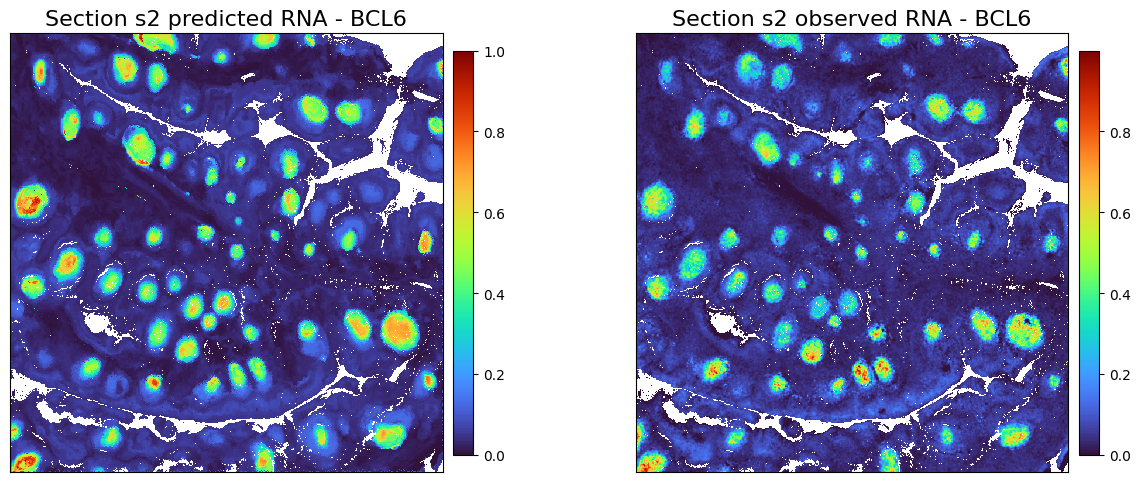

In [30]:
chosed_gene = 'BCL6'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata2_rna_norm, 
                       'Section s2 predicted RNA', 
                       'Section s2 observed RNA',
                        figscale = 100,)
